In [55]:
TRAIN_PATH = 'processed_full_loaded.csv'
SAVE_PATH = 'model.pth'

RANDOM_STATE = 128
EPOCHS = 50
BATCH_SIZE = 32
LR = 1e-3

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cuda:0


In [57]:
class LogisticRegression(nn.Module):
    def __init__(self, D_in=1, D_out=1):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(D_in, D_out)
        
    def forward(self, x):
        y_pred = self.linear(x)

        return y_pred
    
    def predict(self, x):
        result = self.forward(x)


        return torch.sigmoid(result)

In [58]:
def shuffle_data(X, y):
    assert len(X) == len(y)
    
    p = np.random.permutation(len(X))
    
    return X[p], y[p]

In [59]:
data = pd.read_csv(TRAIN_PATH)



In [ ]:

# Count the instances of each label
label_counts = data['label'].value_counts()
print("Initial label counts:", label_counts)

# Find the number of instances in the minority class
min_class_size = label_counts.min()

# Downsample the majority class
balanced_data = pd.concat([
    data[data['label'] == 0].sample(min_class_size, random_state=42),
    data[data['label'] == 1].sample(min_class_size, random_state=42)
])

# Shuffle the DataFrame
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the balanced DataFrame to a new CSV file
balanced_csv_path = 'balanced_full_data.csv'
balanced_data.to_csv(balanced_csv_path, index=False)

print("Balanced dataset saved.")





In [61]:
label_count = data.groupby('label').count()['filename']
print(label_count)

pos_weight = torch.ones([1]) * label_count[0]/label_count[1]
print('pos_weight:', pos_weight)

label
0    253070
1     44593
Name: filename, dtype: int64
pos_weight: tensor([5.6751])


In [67]:
X = data['distance'].to_numpy()
y = data['label'].to_numpy()

In [68]:
X[0]

0.4197084

In [69]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE, stratify=y)

In [70]:
X_train = torch.tensor(X_train).to(device).unsqueeze(dim=1).float()
X_val = torch.tensor(X_val).to(device).unsqueeze(dim=1).float()
y_train = torch.tensor(y_train).to(device).unsqueeze(dim=1).float()
y_val = torch.tensor(y_val).to(device).unsqueeze(dim=1).float()

In [71]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

def live_plot(data_dict, figsize=(7,5), title=''):
    """
    Plot data in real-time.
    Args:
        data_dict (dict): Dictionary of lists to plot.
        figsize (tuple): Figure size.
        title (str): Title of the plot.
    """
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label, data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    display(plt.gcf())
    plt.close()


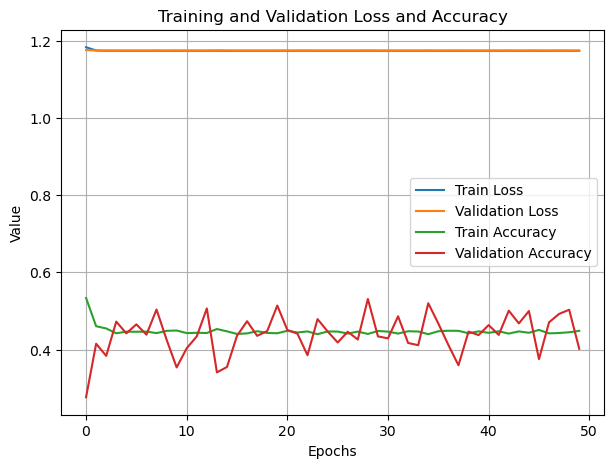

In [72]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# Convert tensors to dataset
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Model, loss, and optimizer
model = LogisticRegression().to(device)
criterion = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

# Initialize losses tracking
losses = []
val_losses = []
best_val_loss = float('inf')

import torch
from sklearn.metrics import accuracy_score

# Initialize metrics storage
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    batch_losses, batch_accuracies = [], []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        preds = torch.sigmoid(y_pred).round()  # Convert logits to binary output
        accuracy = accuracy_score(y_batch.detach().cpu(), preds.detach().cpu())
        batch_losses.append(loss.item())
        batch_accuracies.append(accuracy)
    
    train_losses.append(sum(batch_losses) / len(batch_losses))
    train_accuracies.append(sum(batch_accuracies) / len(batch_accuracies))
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_batch_losses, val_batch_accuracies = [], []
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_preds = torch.sigmoid(y_val_pred).round()
            val_accuracy = accuracy_score(y_val_batch.detach().cpu(), val_preds.detach().cpu())
            val_batch_losses.append(val_loss.item())
            val_batch_accuracies.append(val_accuracy)
    
    val_losses.append(sum(val_batch_losses) / len(val_batch_losses))
    val_accuracies.append(sum(val_batch_accuracies) / len(val_batch_accuracies))
    
    # Live plot update
    live_plot({
        'Train Loss': train_losses,
        'Validation Loss': val_losses,
        'Train Accuracy': train_accuracies,
        'Validation Accuracy': val_accuracies
    }, title='Training and Validation Loss and Accuracy')


ValueError: x and y must have same first dimension, but have shapes (50,) and (0,)

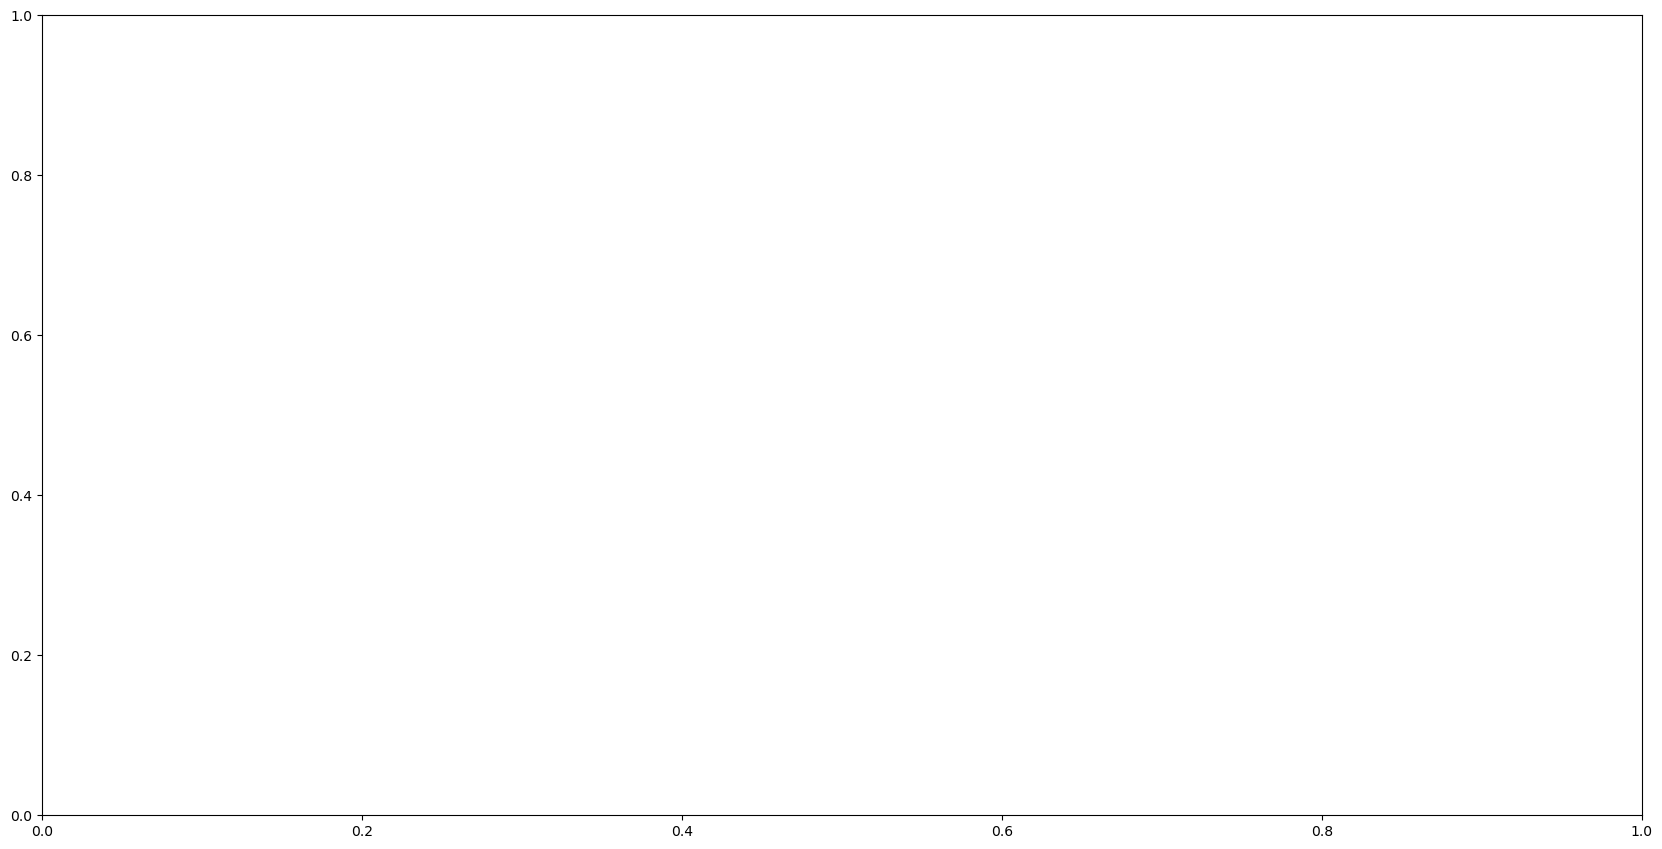

In [73]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_axes([0, 0, 1, 1])

ax.plot(np.arange(EPOCHS), losses)
ax.plot(np.arange(EPOCHS), val_losses)
ax.set_xlabel('epoch', fontsize='xx-large')
ax.set_ylabel('log loss', fontsize='xx-large')
ax.legend(
    ['loss', 'val loss'],
    loc='upper right',
    fontsize='xx-large',
    shadow=True
)
plt.show()

In [29]:
without_weight_criterion = nn.BCELoss(reduction='mean')

classifier.eval()
with torch.no_grad():
    y_val_pred = classifier.predict(X_val)
    val_loss = without_weight_criterion(y_val_pred, y_val)

print('val loss:', val_loss.detach().cpu().numpy())

val loss: 0.68891364


[]

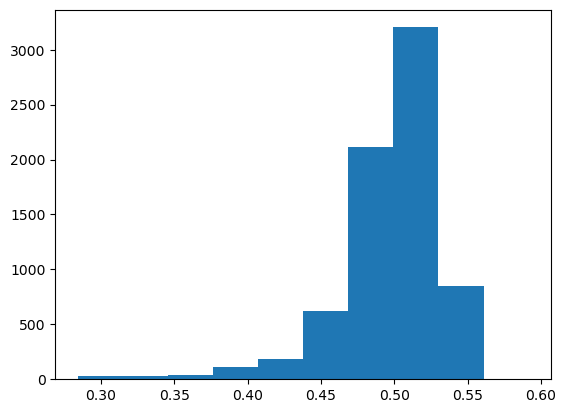

In [31]:
plt.hist(y_val_pred.squeeze(dim=-1).detach().cpu())
plt.plot()